In [2]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os
import warnings

from pathlib import Path

from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict


import models
import utils
import sys
import cv2
from datasetsV2 import get_transform_to_eval, get_transform_to_eval_NO_SRM, get_transform_to_eval_SRM, get_transform_to_eval_Sobel
from torchvision.transforms import ToPILImage

from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import pandas as pd
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,  log_loss
import math

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.1 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [2]:

def get_transform(logs_path):
    if 'baseline' in logs_path:
        print("using without srm")
        return get_transform_to_eval_NO_SRM(224)
    elif "input" in logs_path and "srm" in logs_path:
        print("using input srm")
        return get_transform_to_eval(224)
    elif "input" in logs_path and "sobel" in logs_path:
        print("using input sobel")
        return get_transform_to_eval_Sobel(224)
    elif "branch" in logs_path and "srm" in logs_path:
        print("using branch filter")
        return get_transform_to_eval_NO_SRM(224)
    elif "branch" in logs_path and "sobel" in logs_path:
        print("using branch filter")
        return get_transform_to_eval_NO_SRM(224)
    else:
        print("using branch filter")
        return get_transform_to_eval_NO_SRM(224)

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'

In [4]:
import torch
print('C', torch.cuda.is_available())
device = torch.device(device)
print('E', torch.cuda.get_device_properties(device))

C True
E _CudaDeviceProperties(name='NVIDIA GeForce RTX 4080 SUPER', major=8, minor=9, total_memory=16049MB, multi_processor_count=80)


In [5]:
def preprocess_image_transform(image_path, transform):
    image = Image.open(image_path)
    image = np.array(image)
    augmented = transform(image=image)
    return augmented['image'], image

In [6]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [7]:
result_dict = {}
prob_dict = {}

In [8]:
def detect_deepfake(img, transform, model, cam, model_name):
    
    for dataset, cls in img.items():
        print(f"###################### {dataset} ######################")
        real_image_path = cls['real']
        fake_image_path = cls['fake']
        # print(real_image, fake_image)
        cam_dir = f"cam/{model_name}"

        real_image, original_real = preprocess_image_transform(real_image_path, transform)
        # print(original_real.shape)
        real_image = real_image.unsqueeze(0)

        img_real = real_image.to(device)
        results_real = model(img_real)
        pred_real = torch.sigmoid(results_real)
        # print(pred)
        pred_real = pred_real.to('cpu')
        original_real = np.float32(original_real) / 255
        targets = None
        cam.batch_size = 32
        grayscale_cam = cam(input_tensor=real_image, targets=targets, eigen_smooth=False, aug_smooth=False)
        grayscale_cam = grayscale_cam[0, :]
        # Mstrar CAM na imagem original
        cam_image_real = show_cam_on_image(original_real, grayscale_cam)
        # print(original_real.shape)
        input_image_real = real_image.squeeze(0).cpu()
        input_image_real = input_image_real.numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        input_image_real = input_image_real * std[:, None, None] + mean[:, None, None]
        input_image_real = np.clip(input_image_real, 0, 1)
        input_image_real = input_image_real.transpose((1, 2, 0))
        pred_real = torch.sigmoid(cam.outputs)
        detected_fake = "FAKE" if pred_real.item() > 0.5 else "REAL"
        print(detected_fake, pred_real)
        # filename = f"cam/{model_name}/{dataset}_REAL.jpg"
        # cv2.imwrite(filename, cam_image_real)
        # filename = f"cam/{model_name}/input_{dataset}_REAL.jpg"
        # cv2.imwrite(filename, input_image_real)

        filename1 = f"{cam_dir}/{dataset}_REAL_example.jpg"
        filename2 = f"{cam_dir}/input_{dataset}_REAL_example.jpg"

        if not os.path.exists(cam_dir):
            os.makedirs(cam_dir)


        cv2.imwrite(filename1, cam_image_real)
        cv2.imwrite(filename2, input_image_real)
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title(f'Original - label: REAL | pred:  {detected_fake}, {round(pred_real.item(), 3)}')
        plt.imshow(original_real)
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.title('Input')
        plt.imshow(input_image_real)
        plt.axis('off')
        # Mostrar a imagem CAM
        plt.subplot(1, 3, 3)
        plt.title('CAM')
        plt.imshow(cam_image_real)
        plt.axis('off')
        
        # filename = image_file.split("/")[-1].split('.')[0]
        # cv2.imwrite(f'cam/{filename}_cam.jpg', cam_image)
        filename = f"{model_name}_{dataset}_REAL"
        plt.savefig(f'cam/{model_name}/{filename}.jpg', bbox_inches='tight')
        plt.show()
        

        fake_image, original_fake = preprocess_image_transform(fake_image_path, transform)
        fake_image = fake_image.unsqueeze(0)
        img_real = fake_image.to(device)
        results_real = model(img_real)
        pred = torch.sigmoid(results_real)
        # print(pred)
        pred_fake = pred.to('cpu')
        original_fake = np.float32(original_fake) / 255
        targets = None
        cam.batch_size = 32
        grayscale_cam = cam(input_tensor=fake_image, targets=targets, eigen_smooth=False, aug_smooth=False)
        grayscale_cam = grayscale_cam[0, :]
        # Mstrar CAM na imagem original
        cam_image_fake = show_cam_on_image(original_fake, grayscale_cam)
        input_image_fake = fake_image.squeeze(0)
        # print(input_image_fake.shape)
        input_image_fake = input_image_fake.numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        input_image_fake = input_image_fake * std[:, None, None] + mean[:, None, None]
        input_image_fake = np.clip(input_image_fake, 0, 1)
        input_image_fake = input_image_fake.transpose((1, 2, 0))
        pred_fake = torch.sigmoid(cam.outputs)
        detected_fake = "FAKE" if pred_fake.item() > 0.5 else "REAL"
        print(detected_fake, pred_fake)
 
        
        filename1 = f"{cam_dir}/{dataset}_FAKE.jpg"
        # filename2 = f"{cam_dir}/input_{dataset}_FAKE_example_2.jpg"

        # Verifica se o diretório existe, se não, cria
        if not os.path.exists(cam_dir):
            os.makedirs(cam_dir)

        cv2.imwrite(filename1, cam_image_fake)
        cv2.imwrite(filename2, input_image_fake)

        # cv2.imshow('image window', cam_image_fake)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        plt.subplot(1, 3, 1)
        plt.title(f'Label: FAKE|pred:{detected_fake},{round(pred_fake.item(), 3)}')
        plt.imshow(original_fake)
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.title('Input')
        plt.imshow(input_image_fake)
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.title('CAM')
        plt.imshow(cam_image_fake)
        plt.axis('off')
        
        filename = f"{model_name}_{dataset}_FAKE"
        plt.savefig(f'cam/{model_name}/{filename}.jpg', bbox_inches='tight')
        plt.show()
        


    

In [9]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [10]:
def make_predictions(logs_path, images, trasform_eval, model_name):
    backbone = ''
    args = open(os.path.join(logs_path, 'args.txt'),'r')
    for txt in args:
        if "model" in txt:
            print(txt)
            backbone = txt.split(' ')[-1][:-1]

    model = create_model(
    backbone,
    pretrained=True,
    num_classes=1
)
    model_path = os.path.join(logs_path, 'model_best.pth')
    checkpoint = torch.load(model_path, map_location='cpu')
    utils.load_checkpoint(model, checkpoint['model'])
    model.eval()

    transform = trasform_eval
    model.to(device)
    target_layers = [model.blocks[2].blocks[1][5].attn]
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    detect_deepfake(images, transform, model, cam, model_name)    

In [11]:
# log_path = ['/home/eferreira/master/cross-vit/CrossViT/old_logs/7', '/home/eferreira/master/cross-vit/CrossViT/old_logs/8', '/home/eferreira/master/cross-vit/CrossViT/old_logs/9', '/home/eferreira/master/cross-vit/CrossViT/old_logs/10', '/home/eferreira/master/cross-vit/CrossViT/old_logs/11']
log_path = [
    # "/home/eferreira/master/cross-vit/CrossViT/old_logs/18_baseline_0_5",
    #         "/home/eferreira/master/cross-vit/CrossViT/old_logs/12_srm_input_transform",
    #         "/home/eferreira/master/cross-vit/CrossViT/old_logs/17_sobel_input_transform",
            # '/home/eferreira/master/cross-vit/CrossViT/old_logs/24_srm_l_branch_simple',
            # '/home/eferreira/master/cross-vit/CrossViT/old_logs/28_sobel_l_branch',
            # '/home/eferreira/master/cross-vit/CrossViT/old_logs/31_srm_s_branch',
            # '/home/eferreira/master/cross-vit/CrossViT/old_logs/32_sobel_s_branch',
            '/home/eferreira/master/cross-vit/CrossViT/old_logs/33_srm_l_branch_sobel_s_branch'
            ]
# log_path = [f'/home/eferreira/master/cross-vit/CrossViT/old_logs/{x}' for x in range(0, 7)]
log_path

['/home/eferreira/master/cross-vit/CrossViT/old_logs/33_srm_l_branch_sobel_s_branch']

In [12]:
images_to_paper = {
    'DFDC':{
        'fake': '/home/eferreira/master/storage/dfdc/dfdc/test/reorganized/faces/huxzyvgfcy/0_0.png',
        'real': '/home/eferreira/master/storage/dfdc/dfdc/test/reorganized/faces/acsaejxizf/0_0.png'
    },
    'CELEBDF-V2':{
        'real': '/home/eferreira/master/storage/celeb/celebdf/faces/id42_0002/0_0.png',
        'fake': '/home/eferreira/master/storage/celeb/celebdf/faces/id57_id51_0000/0_0.png'
    },
    'deepfakedetection':{
        'real': '/home/eferreira/master/storage/ff++/ff++/original_sequences/actors/raw/videos/faces/03__talking_angry_couch/0_0.png',
        'fake': '/home/eferreira/master/storage/ff++/ff++/manipulated_sequences/DeepFakeDetection/raw/videos/faces/02_07__kitchen_pan__34PVT42V/30_0.png'
    },
    'deepfakes':{
        'real': '/home/eferreira/master/storage/ff++/ff++/original_sequences/youtube/raw/videos/faces/979/0_0.png',
        'fake': '/home/eferreira/master/storage/ff++/ff++/manipulated_sequences/Deepfakes/raw/videos/faces/093_121/3_0.png'
    },
    'face2face':{
        'real': '/home/eferreira/master/storage/ff++/ff++/original_sequences/actors/raw/videos/faces/17__podium_speech_happy/0_0.png',
        'fake': '/home/eferreira/master/storage/ff++/ff++/manipulated_sequences/Face2Face/raw/videos/faces/043_110/7_0.png'
    },
    'faceshifter':{
        'real': '/home/eferreira/master/storage/ff++/ff++/original_sequences/youtube/raw/videos/faces/319/0_0.png',
        'fake': '/home/eferreira/master/storage/ff++/ff++/manipulated_sequences/FaceShifter/raw/videos/faces/250_461/3_0.png'
    },
    'faceswap':{
        'real': '/home/eferreira/master/storage/ff++/ff++/original_sequences/actors/raw/videos/faces/13__talking_angry_couch/8_0.png',
        'fake': '/home/eferreira/master/storage/ff++/ff++/manipulated_sequences/FaceSwap/raw/videos/faces/190_176/0_0.png'
    },
    'neuraltextures':{
        'real': '/home/eferreira/master/storage/ff++/ff++/original_sequences/youtube/raw/videos/faces/112/0_0.png',
        'fake': '/home/eferreira/master/storage/ff++/ff++/manipulated_sequences/NeuralTextures/raw/videos/faces/139_130/0_0.png'
    },
}

In [13]:
# images_to_paper = {
#     # 'DFDC':{
#     #     'real': '/home/eferreira/master/storage/dfdc/dfdc/test/reorganized/faces/aarpyivfys/0_0.png',
#     #     'fake': '/home/eferreira/master/storage/dfdc/dfdc/test/reorganized/faces/acsaejxizf/0_0.png'
#     # },
#     # 'CELEBDF-V2':{
#     #     'real': '/home/eferreira/master/storage/celeb/celebdf/faces/id42_0002/0_0.png',
#     #     'fake': '/home/eferreira/master/storage/celeb/celebdf/faces/id57_id51_0000/0_0.png'
#     # },
#     # 'FACEFORENSICS++':{
#     #     'real': '/home/eferreira/master/storage/ff++/ff++/original_sequences/actors/raw/videos/faces/10__walking_down_street_outside_angry/294_0.png',
#     #     'fake': '/home/eferreira/master/storage/ff++/ff++/manipulated_sequences/NeuralTextures/raw/videos/faces/216_164/0_0.png'
#     # },
# }

In [14]:
# /home/eferreira/master/storage/ff++/ff++/original_sequences/actors/raw/videos/faces/03__talking_angry_couch/0_0.png

# SEM SRM

using branch filter
33_srm_l_branch_sobel_s_branch
model: crossvit_18_dagger_224_srm_L_sobel_S

ViT with 1 classes.


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmpkwemwsta ...


###################### DFDC ######################
FAKE tensor([[0.9998]], device='cuda:0', grad_fn=<SigmoidBackward0>)


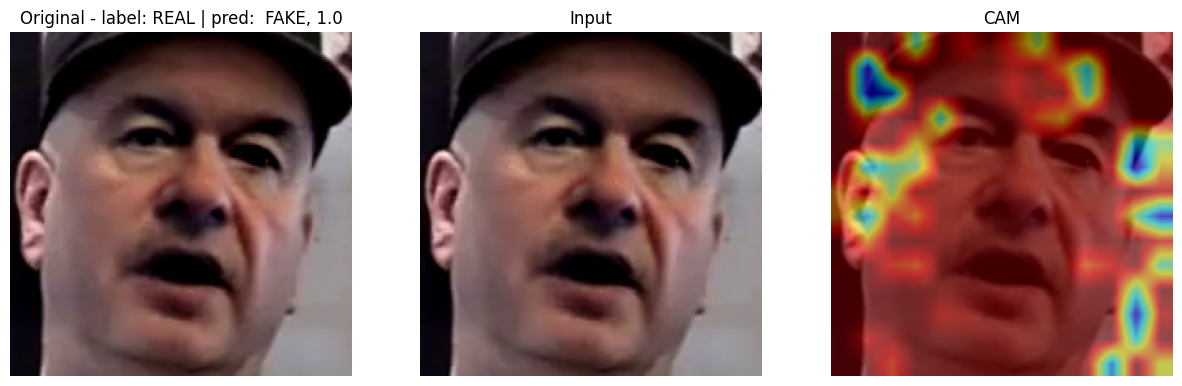

FAKE tensor([[0.9914]], device='cuda:0', grad_fn=<SigmoidBackward0>)


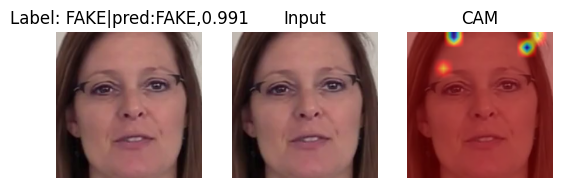

###################### CELEBDF-V2 ######################
FAKE tensor([[0.9400]], device='cuda:0', grad_fn=<SigmoidBackward0>)


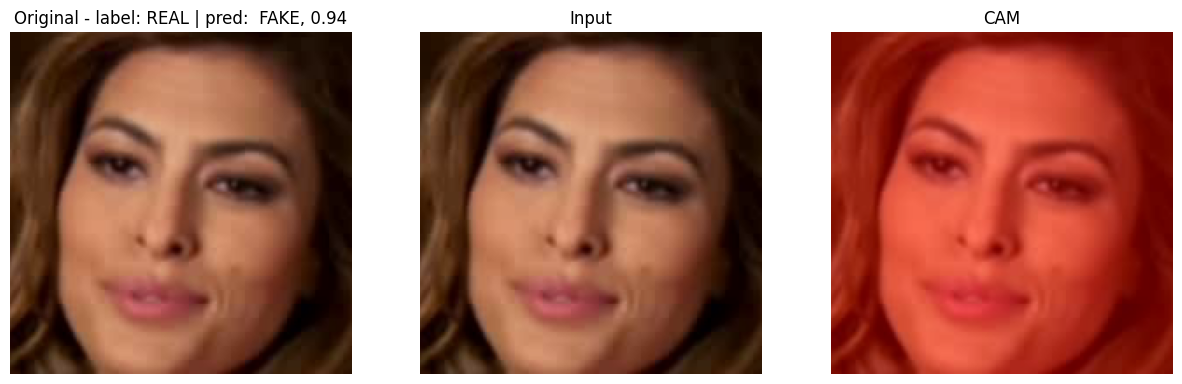

FAKE tensor([[0.9890]], device='cuda:0', grad_fn=<SigmoidBackward0>)


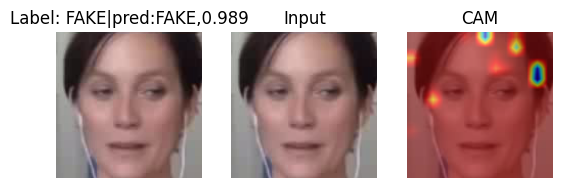

###################### deepfakedetection ######################
REAL tensor([[0.0258]], device='cuda:0', grad_fn=<SigmoidBackward0>)


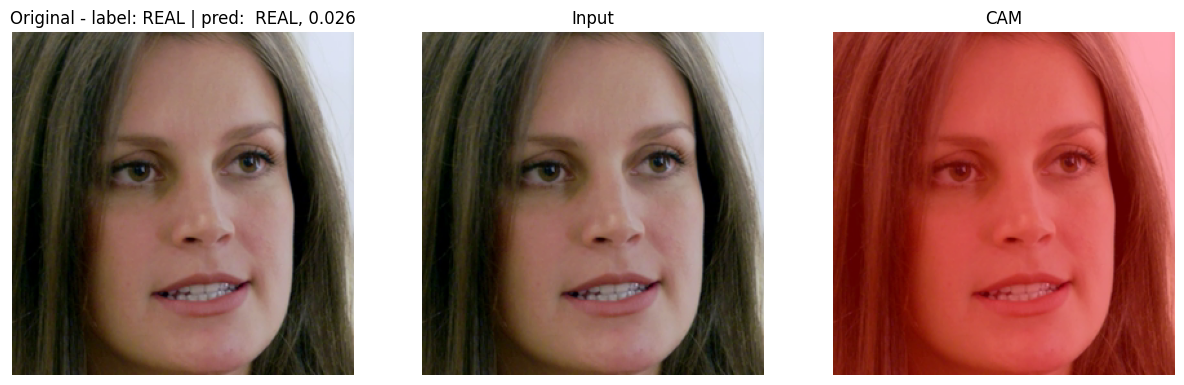

FAKE tensor([[0.8630]], device='cuda:0', grad_fn=<SigmoidBackward0>)


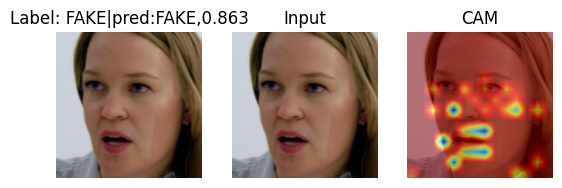

###################### deepfakes ######################
REAL tensor([[0.0136]], device='cuda:0', grad_fn=<SigmoidBackward0>)


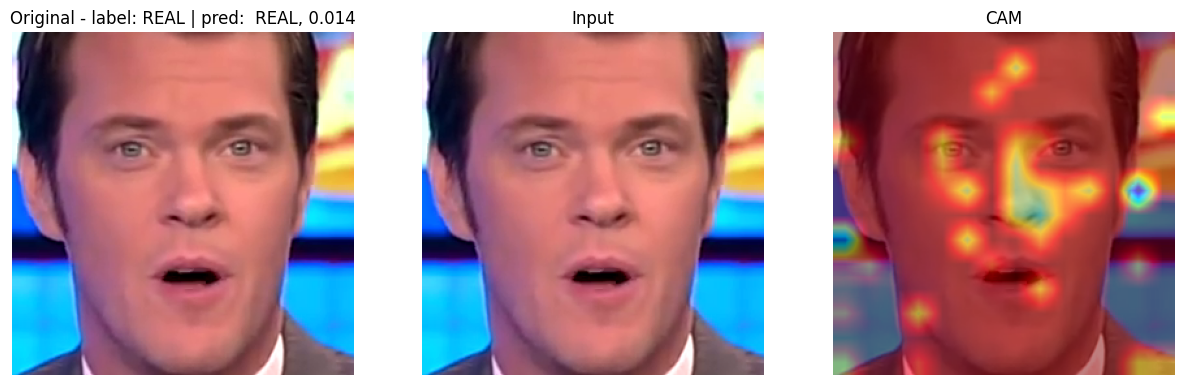

FAKE tensor([[0.6438]], device='cuda:0', grad_fn=<SigmoidBackward0>)


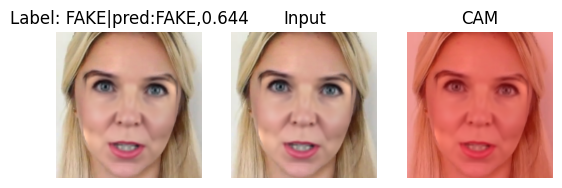

###################### face2face ######################
REAL tensor([[0.0007]], device='cuda:0', grad_fn=<SigmoidBackward0>)


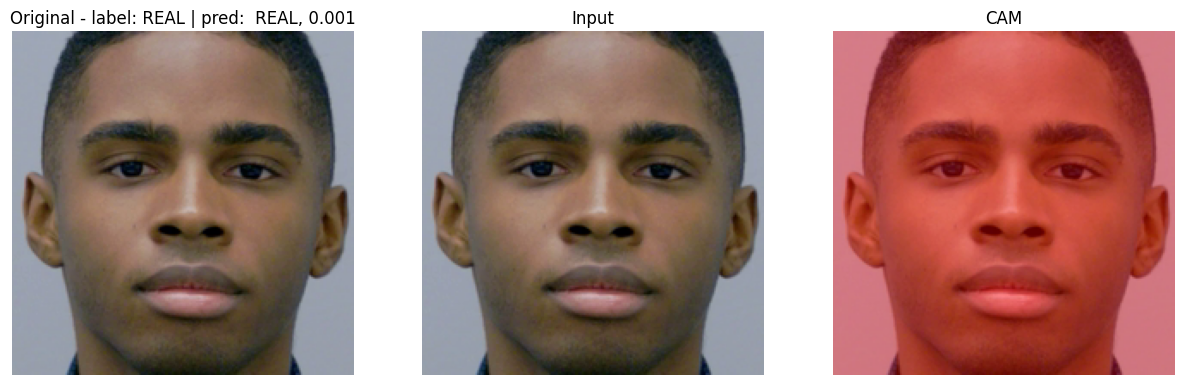

FAKE tensor([[0.9998]], device='cuda:0', grad_fn=<SigmoidBackward0>)


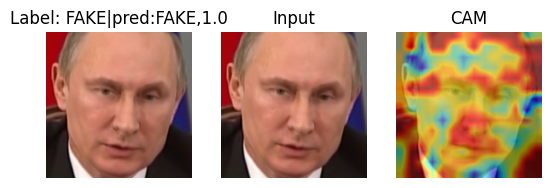

###################### faceshifter ######################
FAKE tensor([[0.9986]], device='cuda:0', grad_fn=<SigmoidBackward0>)


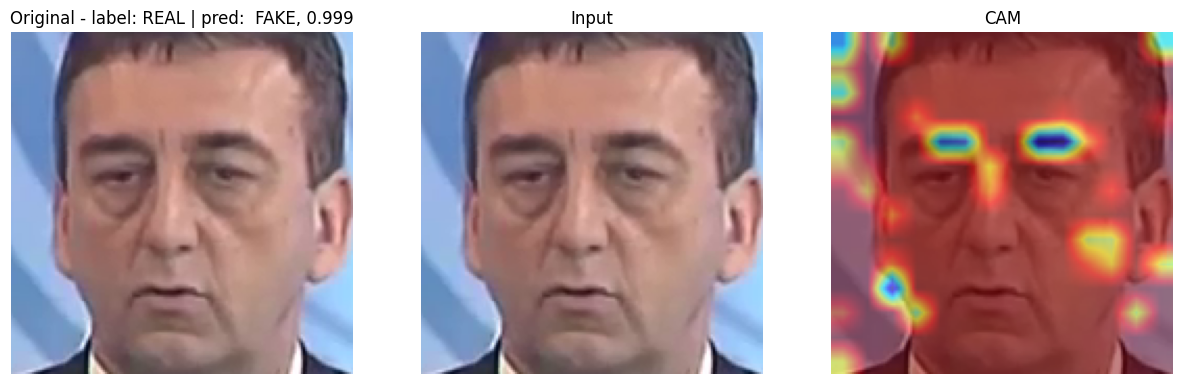

REAL tensor([[0.0005]], device='cuda:0', grad_fn=<SigmoidBackward0>)


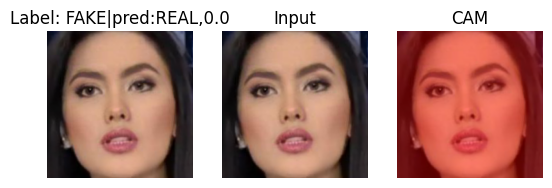

###################### faceswap ######################
REAL tensor([[0.0005]], device='cuda:0', grad_fn=<SigmoidBackward0>)


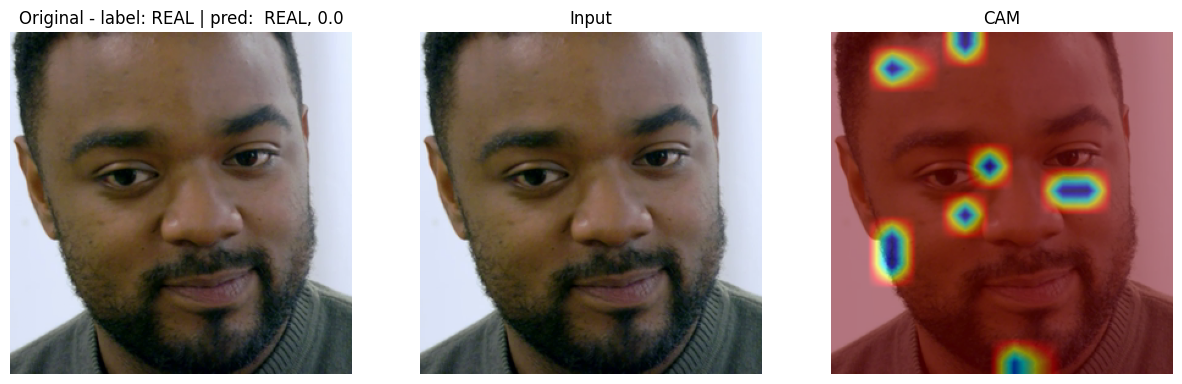

REAL tensor([[0.0257]], device='cuda:0', grad_fn=<SigmoidBackward0>)


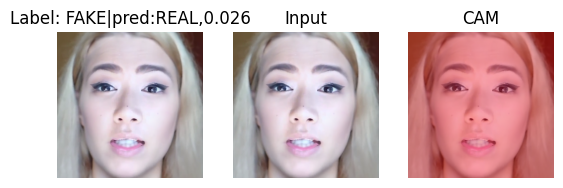

###################### neuraltextures ######################
REAL tensor([[0.0005]], device='cuda:0', grad_fn=<SigmoidBackward0>)


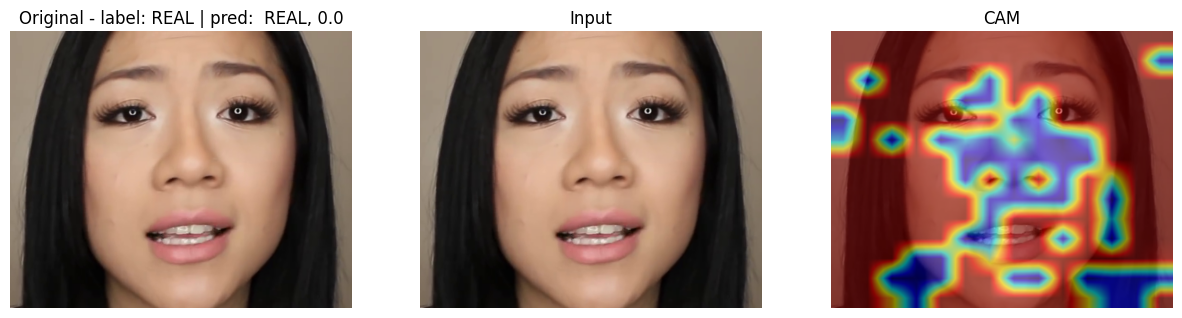

REAL tensor([[0.0047]], device='cuda:0', grad_fn=<SigmoidBackward0>)


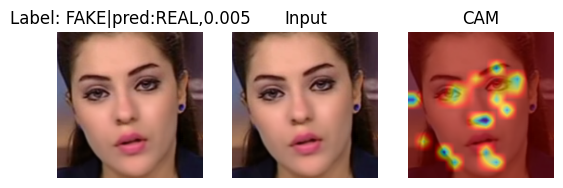

In [15]:
for path in log_path:
    transform = get_transform(path)
    model_name = path.split("/")[-1]
    print(model_name)
    make_predictions(path, images_to_paper, transform, model_name)

In [16]:
# log_path = '/home/eferreira/master/cross-vit/CrossViT/old_logs/12'
# transform = get_transform_to_eval_NO_SRM(224)
# model_name = path.split("/")[-1]
# make_predictions(log_path, images_to_paper, transform, model_name)

In [17]:
# log_path = '/home/eferreira/master/cross-vit/CrossViT/old_logs/17_sobel_0_5'
# transform = get_transform_to_eval_NO_SRM(224)
# model_name = path.split("/")[-1]
# make_predictions(log_path, images_to_paper, transform, "sobel")

In [18]:
# images_to_paper = {
#     'KAGGLE':{
#         'real': '/home/eferreira/master/kaggle/real_vs_fake/real-vs-fake/test/real/00004.jpg',
#         'fake': '/home/eferreira/master/kaggle/real_vs_fake/real-vs-fake/test/fake/0ARJBWDKA1.jpg'
#     }
# }

In [19]:
# log_path = '/home/eferreira/master/cross-vit/CrossViT/old_logs/12'
# transform = get_transform_to_eval_SRM(224)
# make_predictions(log_path, images_to_paper, transform)

In [9]:
df = pd.read_csv("logs/val_images_used.csv")
df

,Unnamed: 0,filename,label
0,0,6997_92977_0.png,0
1,1,7299_102448_0.png,0
2,2,6339_72474_0.png,0
3,3,6413_74819_0.png,0
4,4,6847_88384_0.png,0
...,...,...,...
54597,54597,7999_124015_1.png,1
54598,54598,7999_124016_1.png,1
54599,54599,7999_124017_1.png,1
54600,54600,7999_124018_1.png,1


In [10]:
df['label'].value_counts()

label
0    27301
1    27301
Name: count, dtype: int64